In [56]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [57]:
from langchain_groq import ChatGroq

In [58]:
llm = ChatGroq(model = "openai/gpt-oss-20b", api_key = os.getenv("GROQ_API_KEY"))

In [59]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results = 2)

In [60]:
def multiply(a:int, b:int) -> int:
    """Multiply two integers, use only if asked to calculate a product.

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """

    return a*b

In [61]:
tools = [tool, multiply]

In [62]:
llm_with_tools = llm.bind_tools(tools)

In [63]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [64]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [65]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", tool_calling_llm)
graph_builder.add_node("tool_node", ToolNode(tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools" : "tool_node",
        "end" : END
    }
)

graph_builder.add_edge("tool_node", END)
graph = graph_builder.compile()

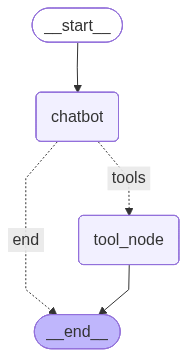

In [66]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
response = graph.invoke({"messages": "give me recent ai news made yesterday"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

give me recent ai news made yesterday
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_1c2d2120-0f55-4258-94f3-e6b4ccd6d2d3)
 Call ID: fc_1c2d2120-0f55-4258-94f3-e6b4ccd6d2d3
  Args:
    query: AI news yesterday
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news yesterday", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://pitchbook.com/news/articles/ai-down-rounds-rise-as-questions-grow-over-europes-bubble", "title": "AI down rounds rise as questions grow over Europe’s bubble - PitchBook", "score": 0.66366893, "published_date": "Tue, 25 Nov 2025 14:12:34 GMT", "content": "Last month, legal AI startup Robin AI, backed by Revolut founder Nik Storonsky, was reportedly listed f

In [72]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", tool_calling_llm)
graph_builder.add_node("tool_node", ToolNode(tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools" : "tool_node",
        "__end__" : END
    }
)

graph_builder.add_edge("tool_node", "chatbot")
graph = graph_builder.compile()

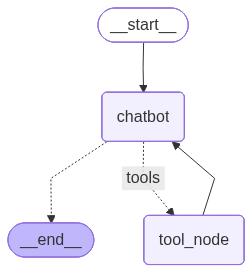

In [73]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [74]:
response = graph.invoke({"messages": "give me recent ai news made yesterday and tell me what is 2 multiplied by 3"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

give me recent ai news made yesterday and tell me what is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_b06d8c14-0126-481d-b643-aada9875266a)
 Call ID: fc_b06d8c14-0126-481d-b643-aada9875266a
  Args:
    query: AI news yesterday
    search_depth: basic
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news yesterday", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/technology/artificial-intelligence/", "title": "AI News | Latest Headlines and Developments | Reuters", "content": "Artificial Intelligence · 16 hours ago. Alphabet races toward $4 trillion valuation as AI-fueled gains accelerate · 14 hours ago. Amazon pledges up to $50", "score": 0.585789, "raw_content": null}, {"url": "

In [75]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", tool_calling_llm)
graph_builder.add_node("tool_node", ToolNode(tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools" : "tool_node",
        "__end__" : END
    }
)

graph_builder.add_edge("tool_node", "chatbot")
graph = graph_builder.compile(checkpointer = memory)

In [76]:
config = {"configurable" : {"thread_id" : "1"}}

In [ ]:
response = graph.invoke({"messages": "what is my name"}, config=config,)

In [80]:
response["messages"][-1].content

'Nice to meet you, Temi! How can I help you today?'

In [81]:
response["messages"][-1].content

'Nice to meet you, Temi! How can I help you today?'

In [82]:
response = graph.invoke({"messages": "what is my name"}, config=config,)

In [83]:
response["messages"][-1].content

'Your name is Temi.'